# Case Study - Easy Visa For Foreign Workers

### Problem Description

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

# OBJECTIVE

### In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

### Need to shortlist candidates with higher chances of VISA approval.

## Import Libraries

In [6]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

In [8]:
%matplotlib inline
# all the basic libraries that we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style= 'darkgrid')

# pre-processing method
from sklearn.model_selection import train_test_split

# the regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# methods and classes for evaluation
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import cross_validate
import time

## Importing FIile

In [10]:
df = pd.read_csv('EasyVisa.csv')  # import the csv file
df.head(10)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified
5,EZYV06,Asia,Master's,Y,N,2339,2012,South,78252.1400,Year,Y,Certified
6,EZYV07,Asia,Bachelor's,N,N,4985,1994,South,53635.3900,Year,Y,Certified
7,EZYV08,North America,Bachelor's,Y,N,3035,1924,West,418.2298,Hour,Y,Denied
8,EZYV09,Asia,Bachelor's,N,N,4810,2012,Midwest,74362.1900,Year,Y,Certified
9,EZYV10,Europe,Doctorate,Y,N,2251,1995,South,67514.7600,Year,Y,Certified


In [13]:
df.shape

(25480, 12)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [17]:
df.isna().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

In [19]:
df['case_status'].value_counts()

case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

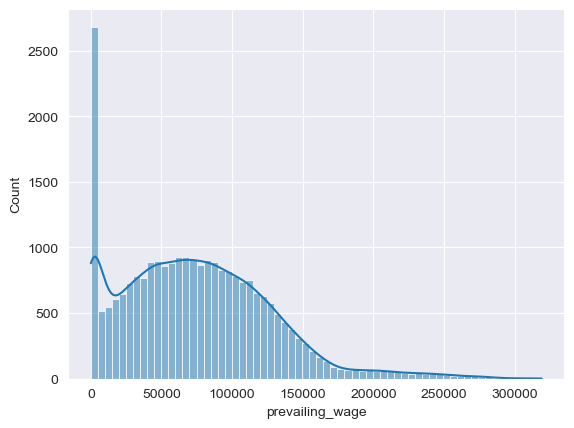

In [21]:
sns.histplot(data = df, x = 'prevailing_wage', kde = True);

In [23]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize)  # creating the 2 subplots
    
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="violet")  # boxplot will be created and a star will indicate the mean value of the column
    
    if bins:
      sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter")
    else: 
      sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)  # For histogram
    
    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")  # Add mean to the histogram
    
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")  # Add median to the histogram

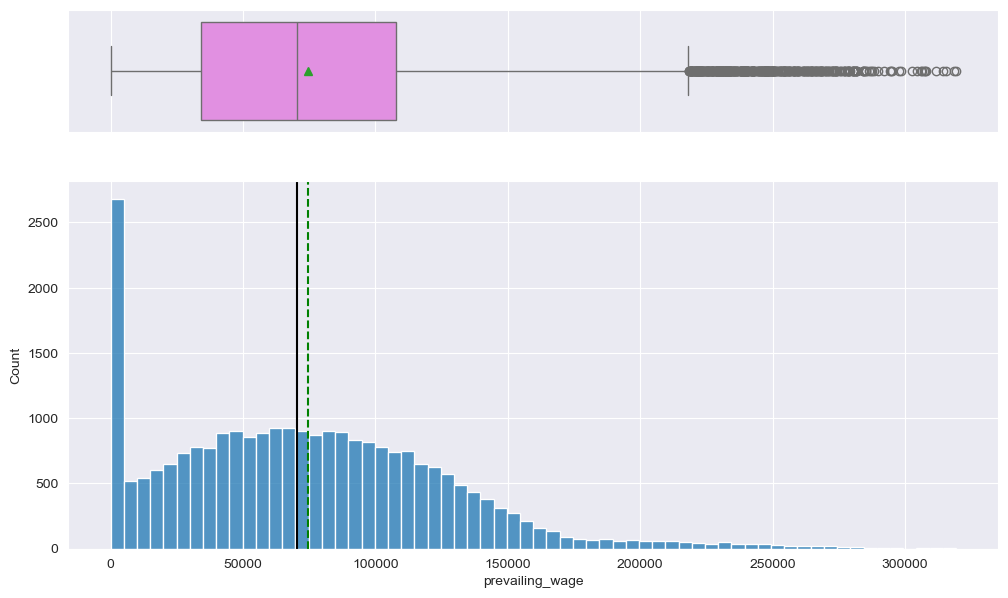

In [25]:
histogram_boxplot(df,'prevailing_wage')

- *There are a lot of outliners for the average wage of employees*
- *Most empoyees are paid around 70000 dollars*

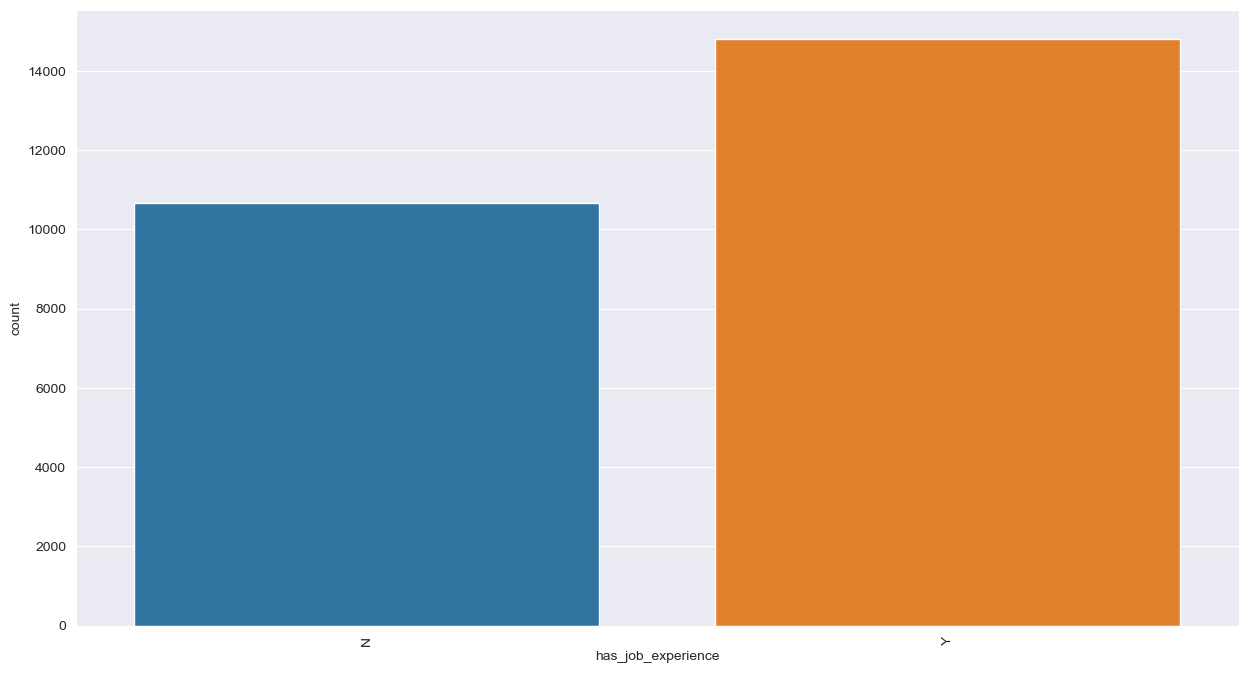

In [28]:
plt.figure(figsize=(15,8))
sns.countplot(data=df, x='has_job_experience', hue='has_job_experience')
plt.xticks(rotation=90);

### *Most of them has Job Experience*

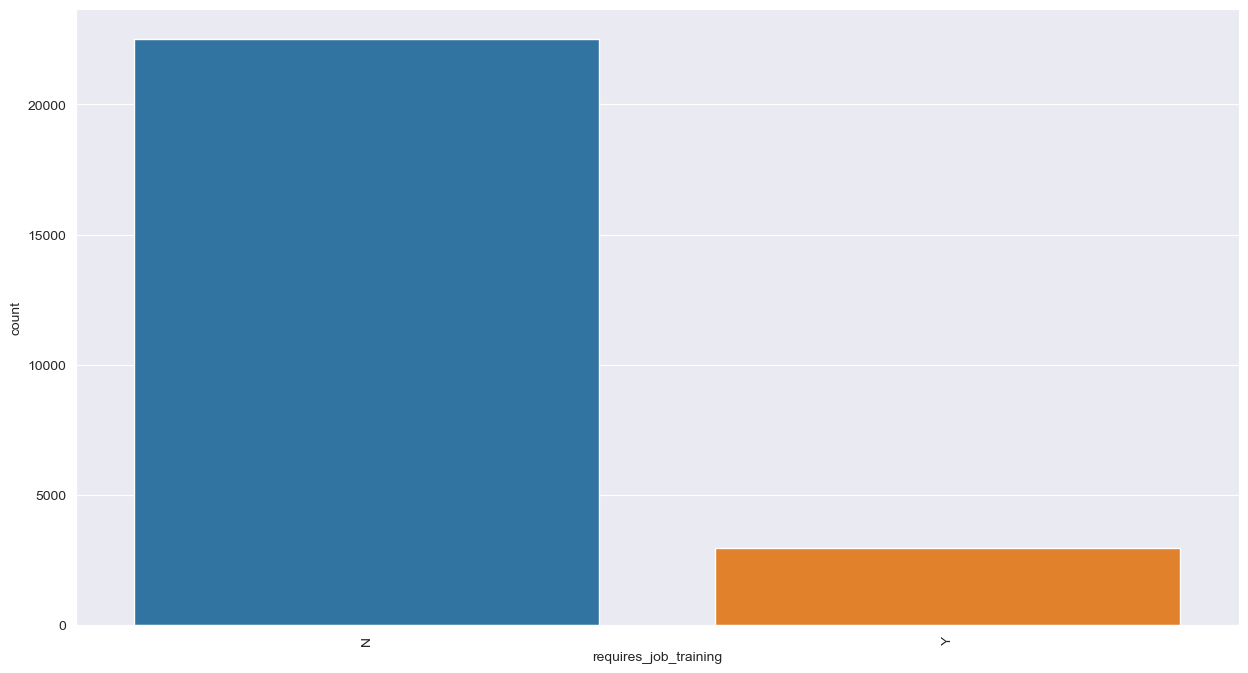

In [31]:
plt.figure(figsize=(15,8))
sns.countplot(data=df, x='requires_job_training', hue='requires_job_training')
plt.xticks(rotation=90);

### *Job Training is not required for most*

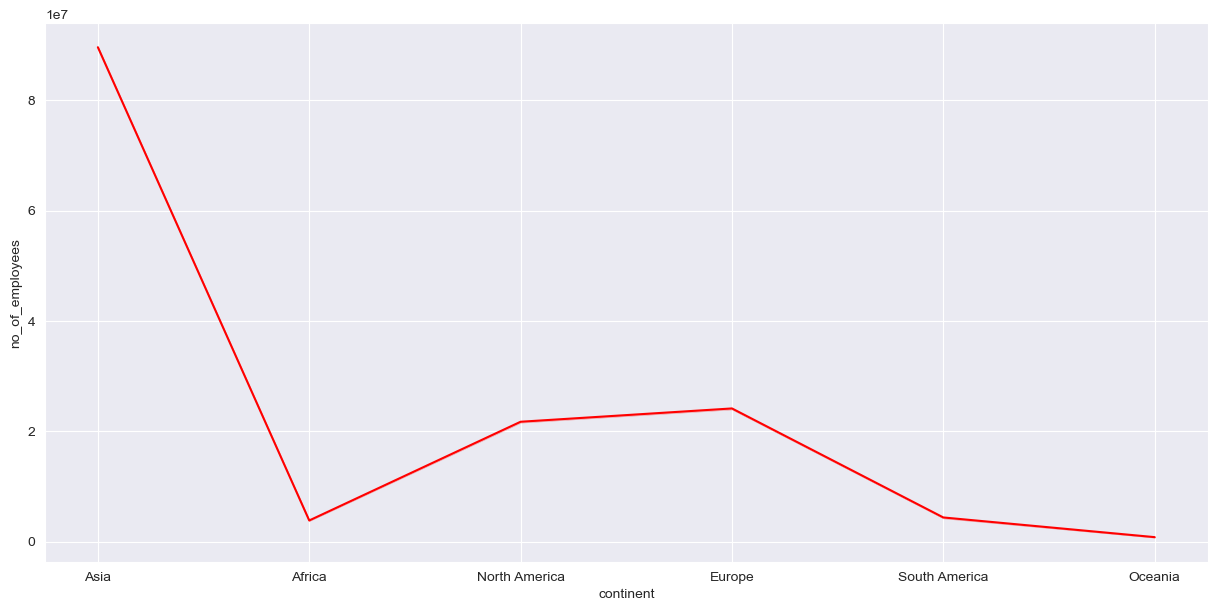

In [34]:
plt.figure(figsize=(15,7))
sns.lineplot(data=df, x="continent", y="no_of_employees", errorbar=('ci', False), color="red", estimator='sum')
plt.ylabel('no_of_employees')
plt.xlabel('continent')
plt.show()

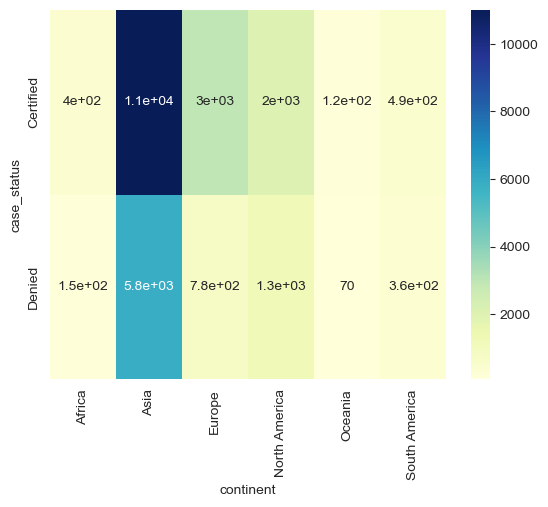

In [36]:
cross_tab = pd.crosstab(df['case_status'], df['continent'])
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu')
plt.show()

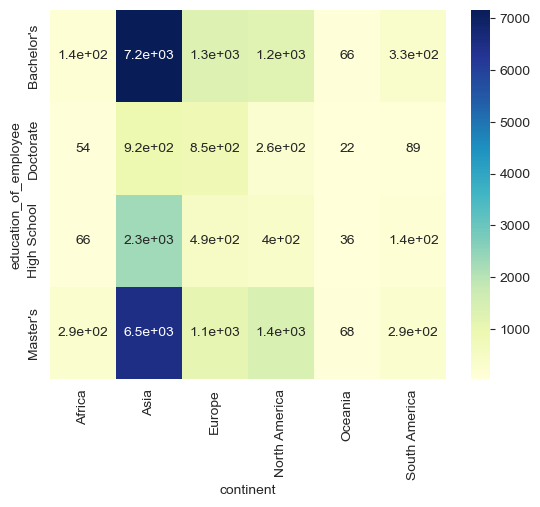

In [38]:
cross_tab = pd.crosstab(df['education_of_employee'], df['continent'])
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu')
plt.show()

array([[<Axes: title={'center': 'Africa'}>,
        <Axes: title={'center': 'Asia'}>],
       [<Axes: title={'center': 'Europe'}>,
        <Axes: title={'center': 'North America'}>],
       [<Axes: title={'center': 'Oceania'}>,
        <Axes: title={'center': 'South America'}>]], dtype=object)

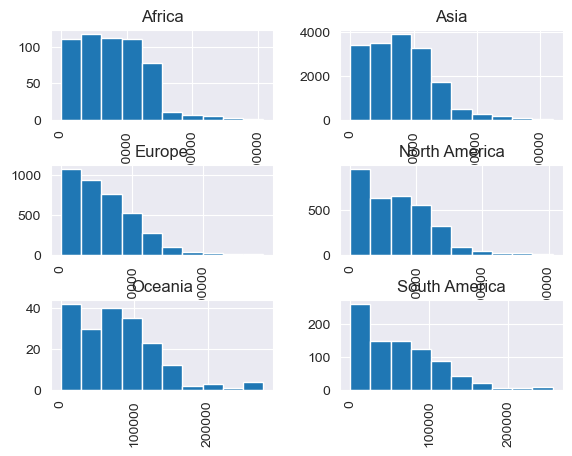

In [40]:
df.hist(by='continent',column = 'prevailing_wage')

- It seems Asian has the most number of people to get certified and also are mostly educated with respect to other countires
- While Ocenia are the least

## Lets convert the columns with an 'object' datatype into categorical variables

In [44]:
for feature in df.columns: # Loop through all columns in the dataframe
    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
        df[feature] = pd.Categorical(df[feature])# Replace strings with an integer
df.head(10)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified
5,EZYV06,Asia,Master's,Y,N,2339,2012,South,78252.1400,Year,Y,Certified
6,EZYV07,Asia,Bachelor's,N,N,4985,1994,South,53635.3900,Year,Y,Certified
7,EZYV08,North America,Bachelor's,Y,N,3035,1924,West,418.2298,Hour,Y,Denied
8,EZYV09,Asia,Bachelor's,N,N,4810,2012,Midwest,74362.1900,Year,Y,Certified
9,EZYV10,Europe,Doctorate,Y,N,2251,1995,South,67514.7600,Year,Y,Certified


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   case_id                25480 non-null  category
 1   continent              25480 non-null  category
 2   education_of_employee  25480 non-null  category
 3   has_job_experience     25480 non-null  category
 4   requires_job_training  25480 non-null  category
 5   no_of_employees        25480 non-null  int64   
 6   yr_of_estab            25480 non-null  int64   
 7   region_of_employment   25480 non-null  category
 8   prevailing_wage        25480 non-null  float64 
 9   unit_of_wage           25480 non-null  category
 10  full_time_position     25480 non-null  category
 11  case_status            25480 non-null  category
dtypes: category(9), float64(1), int64(2)
memory usage: 2.0 MB


In [48]:
print(df.continent.value_counts())
print(df.education_of_employee.value_counts())
print(df.has_job_experience.value_counts())
print(df.requires_job_training.value_counts())
print(df.region_of_employment.value_counts())
print(df.unit_of_wage.value_counts())
print(df.full_time_position.value_counts())
print(df.case_status.value_counts())

continent
Asia             16861
Europe            3732
North America     3292
South America      852
Africa             551
Oceania            192
Name: count, dtype: int64
education_of_employee
Bachelor's     10234
Master's        9634
High School     3420
Doctorate       2192
Name: count, dtype: int64
has_job_experience
Y    14802
N    10678
Name: count, dtype: int64
requires_job_training
N    22525
Y     2955
Name: count, dtype: int64
region_of_employment
Northeast    7195
South        7017
West         6586
Midwest      4307
Island        375
Name: count, dtype: int64
unit_of_wage
Year     22962
Hour      2157
Week       272
Month       89
Name: count, dtype: int64
full_time_position
Y    22773
N     2707
Name: count, dtype: int64
case_status
Certified    17018
Denied        8462
Name: count, dtype: int64


In [50]:
import pandas as pd

# Define your replacement structure
replaceStruct = {
    "education_of_employee": {"High School": 1, "Bachelor's": 2, "Master's": 3, "Doctorate": 4},
    "has_job_experience": {"Y": 1, "N": 2},
    "requires_job_training": {"Y": 1, "N": 2},
    "full_time_position": {"Y": 1, "N": 2},
    "case_status": {"Certified": 1, "Denied": 2}
}

# List of columns to one-hot encode
oneHotCols = ["continent", "region_of_employment", "unit_of_wage"]

# Replace categorical data with numerical values
visaData = df.replace(replaceStruct)

# Convert replaced columns to integer type
for col, mapping in replaceStruct.items():
    visaData[col] = visaData[col].astype(int)

# One-hot encode the specified columns
visaData = pd.get_dummies(visaData, columns=oneHotCols)

# Ensure all one-hot encoded columns are integers
visaData = visaData.astype({col: 'int' for col in visaData.columns if visaData[col].dtype == 'bool'})

# Display information about the transformed dataframe
visaData.head(10)


C:\Users\anuva\AppData\Local\Temp\ipykernel_11028\1278587484.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  visaData = df.replace(replaceStruct)
C:\Users\anuva\AppData\Local\Temp\ipykernel_11028\1278587484.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  visaData = df.replace(replaceStruct)
C:\Users\anuva\AppData\Local\Temp\ipykernel_11028\1278587484.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`.

,case_id,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,prevailing_wage,full_time_position,case_status,continent_Africa,...,continent_South America,region_of_employment_Island,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,unit_of_wage_Hour,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year
0,EZYV01,1,2,2,14513,2007,592.2029,1,2,0,...,0,0,0,0,0,1,1,0,0,0
1,EZYV02,3,1,2,2412,2002,83425.6500,1,1,0,...,0,0,0,1,0,0,0,0,0,1
2,EZYV03,2,2,1,44444,2008,122996.8600,1,2,0,...,0,0,0,0,0,1,0,0,0,1
3,EZYV04,2,2,2,98,1897,83434.0300,1,2,0,...,0,0,0,0,0,1,0,0,0,1
4,EZYV05,3,1,2,1082,2005,149907.3900,1,1,1,...,0,0,0,0,1,0,0,0,0,1
5,EZYV06,3,1,2,2339,2012,78252.1400,1,1,0,...,0,0,0,0,1,0,0,0,0,1
6,EZYV07,2,2,2,4985,1994,53635.3900,1,1,0,...,0,0,0,0,1,0,0,0,0,1
7,EZYV08,2,1,2,3035,1924,418.2298,1,2,0,...,0,0,0,0,0,1,1,0,0,0
8,EZYV09,2,2,2,4810,2012,74362.1900,1,1,0,...,0,0,1,0,0,0,0,0,0,1
9,EZYV10,4,1,2,2251,1995,67514.7600,1,1,0,...,0,0,0,0,1,0,0,0,0,1


In [52]:
visaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   case_id                         25480 non-null  category
 1   education_of_employee           25480 non-null  int32   
 2   has_job_experience              25480 non-null  int32   
 3   requires_job_training           25480 non-null  int32   
 4   no_of_employees                 25480 non-null  int64   
 5   yr_of_estab                     25480 non-null  int64   
 6   prevailing_wage                 25480 non-null  float64 
 7   full_time_position              25480 non-null  int32   
 8   case_status                     25480 non-null  int32   
 9   continent_Africa                25480 non-null  int32   
 10  continent_Asia                  25480 non-null  int32   
 11  continent_Europe                25480 non-null  int32   
 12  continent_North Am

In [54]:
visaData = visaData.drop('case_id', axis=1)
visaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   education_of_employee           25480 non-null  int32  
 1   has_job_experience              25480 non-null  int32  
 2   requires_job_training           25480 non-null  int32  
 3   no_of_employees                 25480 non-null  int64  
 4   yr_of_estab                     25480 non-null  int64  
 5   prevailing_wage                 25480 non-null  float64
 6   full_time_position              25480 non-null  int32  
 7   case_status                     25480 non-null  int32  
 8   continent_Africa                25480 non-null  int32  
 9   continent_Asia                  25480 non-null  int32  
 10  continent_Europe                25480 non-null  int32  
 11  continent_North America         25480 non-null  int32  
 12  continent_Oceania               

## Split the Data into train and test

In [57]:
X = visaData.drop("case_status" , axis=1)
y = visaData.pop("case_status")

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1,stratify=y)

**Before building the model, let's create functions to calculate different metrics- Accuracy, Recall and Precision and plot the confusion matrix.**

In [62]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [64]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

### Bagging Classifier

In [67]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [69]:
#base_estimator for bagging classifier is a decision tree by default
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(random_state=1)

In [71]:
#Using above defined function to get accuracy, recall and precision on train and test set
bagging_estimator_score=get_metrics_score(bagging_estimator)

Accuracy on training set :  0.97835837631756
Accuracy on test set :  0.7104918890633176
Recall on training set :  0.9963065558633426
Recall on test set :  0.8423114593535749
Precision on training set :  0.971992465809516
Precision on test set :  0.7533286615276804


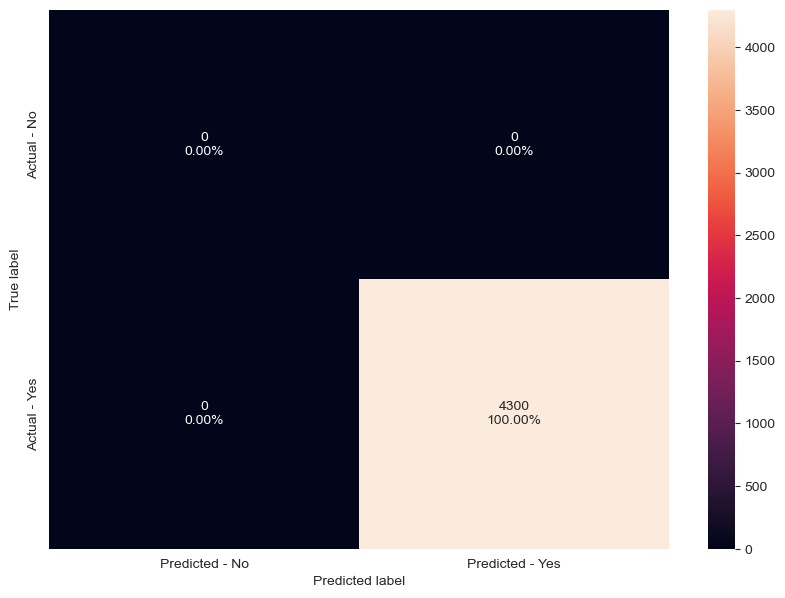

In [73]:
make_confusion_matrix(bagging_estimator,y_test)

### Random Forest Classifier

In [76]:
#Train the random forest classifier
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [77]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_score=get_metrics_score(rf_estimator)

Accuracy on training set :  0.999943933617403
Accuracy on test set :  0.7354788069073783
Recall on training set :  1.0
Recall on test set :  0.8536728697355533
Precision on training set :  0.9999160651334564
Precision on test set :  0.7736552458725369


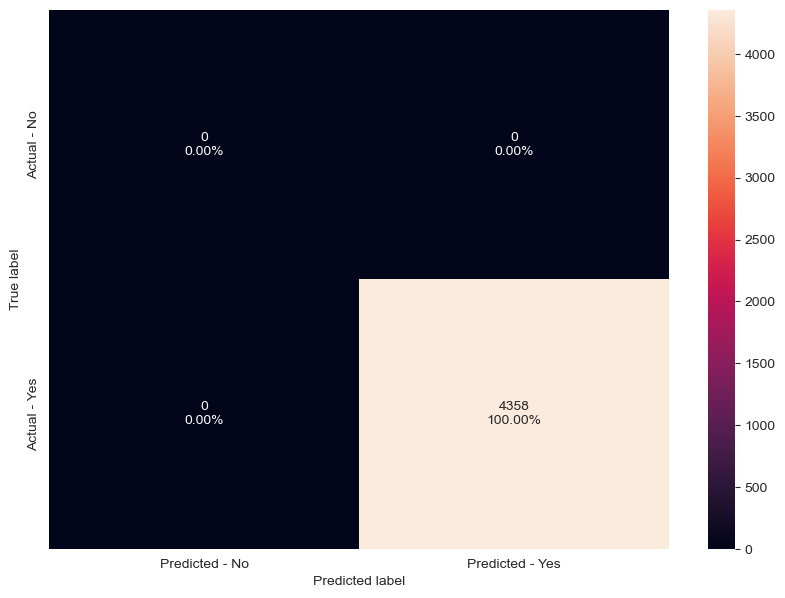

In [78]:
make_confusion_matrix(rf_estimator,y_test)

**With default parameters:**

- Both models are giving similar performance.
- Random Forest is giving a better recall than Bagging but there are a lot of outliners.

## Decision Tree

In [82]:
from sklearn.tree import DecisionTreeClassifier
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [83]:
print(dTree.score(X_train, y_train))
print(dTree.score(X_test, y_test))

1.0
0.6724228152799582


In [154]:
dTree=get_metrics_score(dTree)

Accuracy on training set :  1.0
Accuracy on test set :  0.6724228152799582
Recall on training set :  1.0
Recall on test set :  0.7512242899118511
Precision on training set :  1.0
Precision on test set :  0.7565594791872164


In [84]:
from sklearn.tree import export_graphviz

train_char_label = ['No', 'Yes']
Visa_Tree_File = open('visa_tree.dot','w')
dot_data = export_graphviz(dTree, out_file=Visa_Tree_File, feature_names = list(X_train), class_names = list(train_char_label))
Visa_Tree_File.close()

In [85]:
from os import system
from IPython.display import Image



retCode = system("dot -Tpng visa_tree.dot -o visa_tree.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("visa_tree.png"))

system command returning error: 1


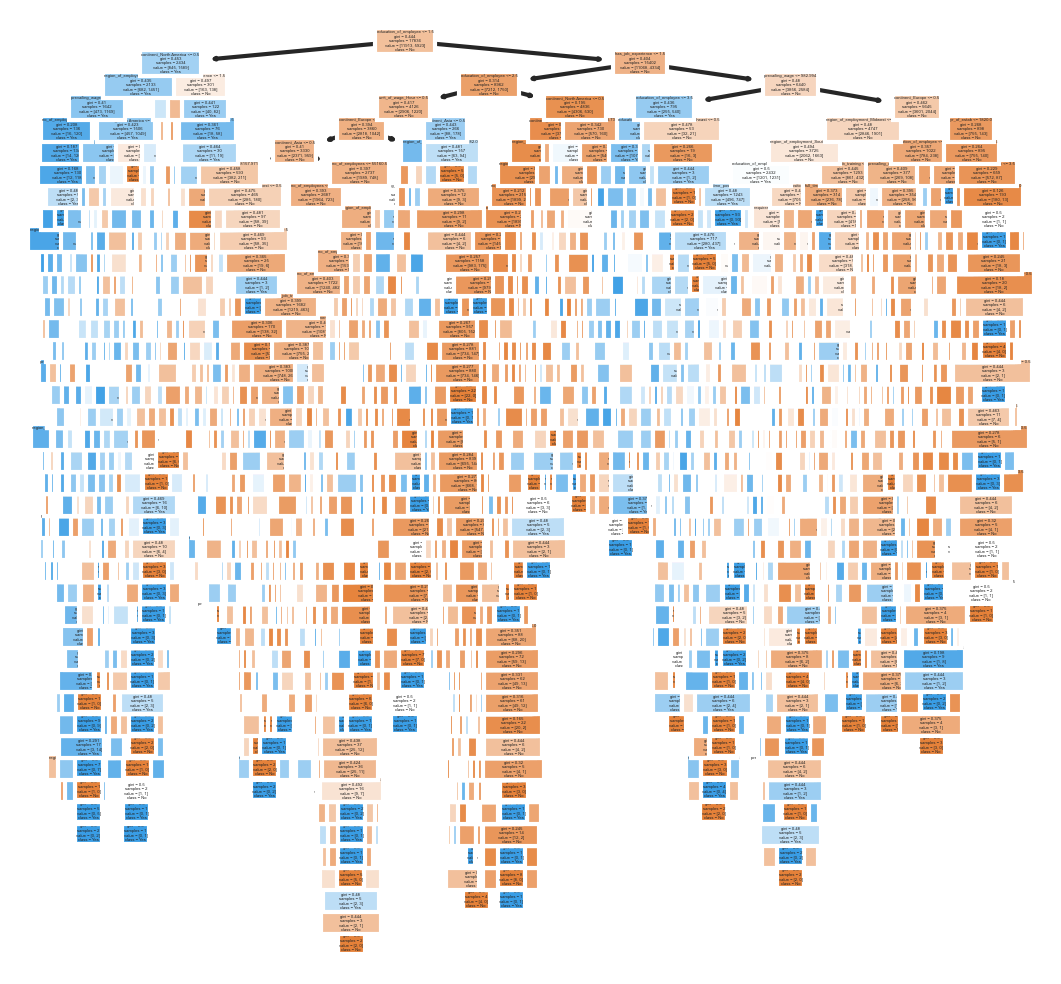

In [92]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fn = list(X_train)
cn = ['No', 'Yes']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=300)
plot_tree(dTree, feature_names = fn, class_names=cn, filled = True)

fig.savefig('tree.png')

- Desicision tree has even more Outliners and is working much worse than Random Forest Classifier and Bagging
- Lets try reducing the overfitting

## Reducing over fitting (Regularization)

In [94]:
dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state=1)
dTreeR.fit(X_train, y_train)
print(dTreeR.score(X_train, y_train))
print(dTreeR.score(X_test, y_test))

0.729367571204306
0.7327315541601256


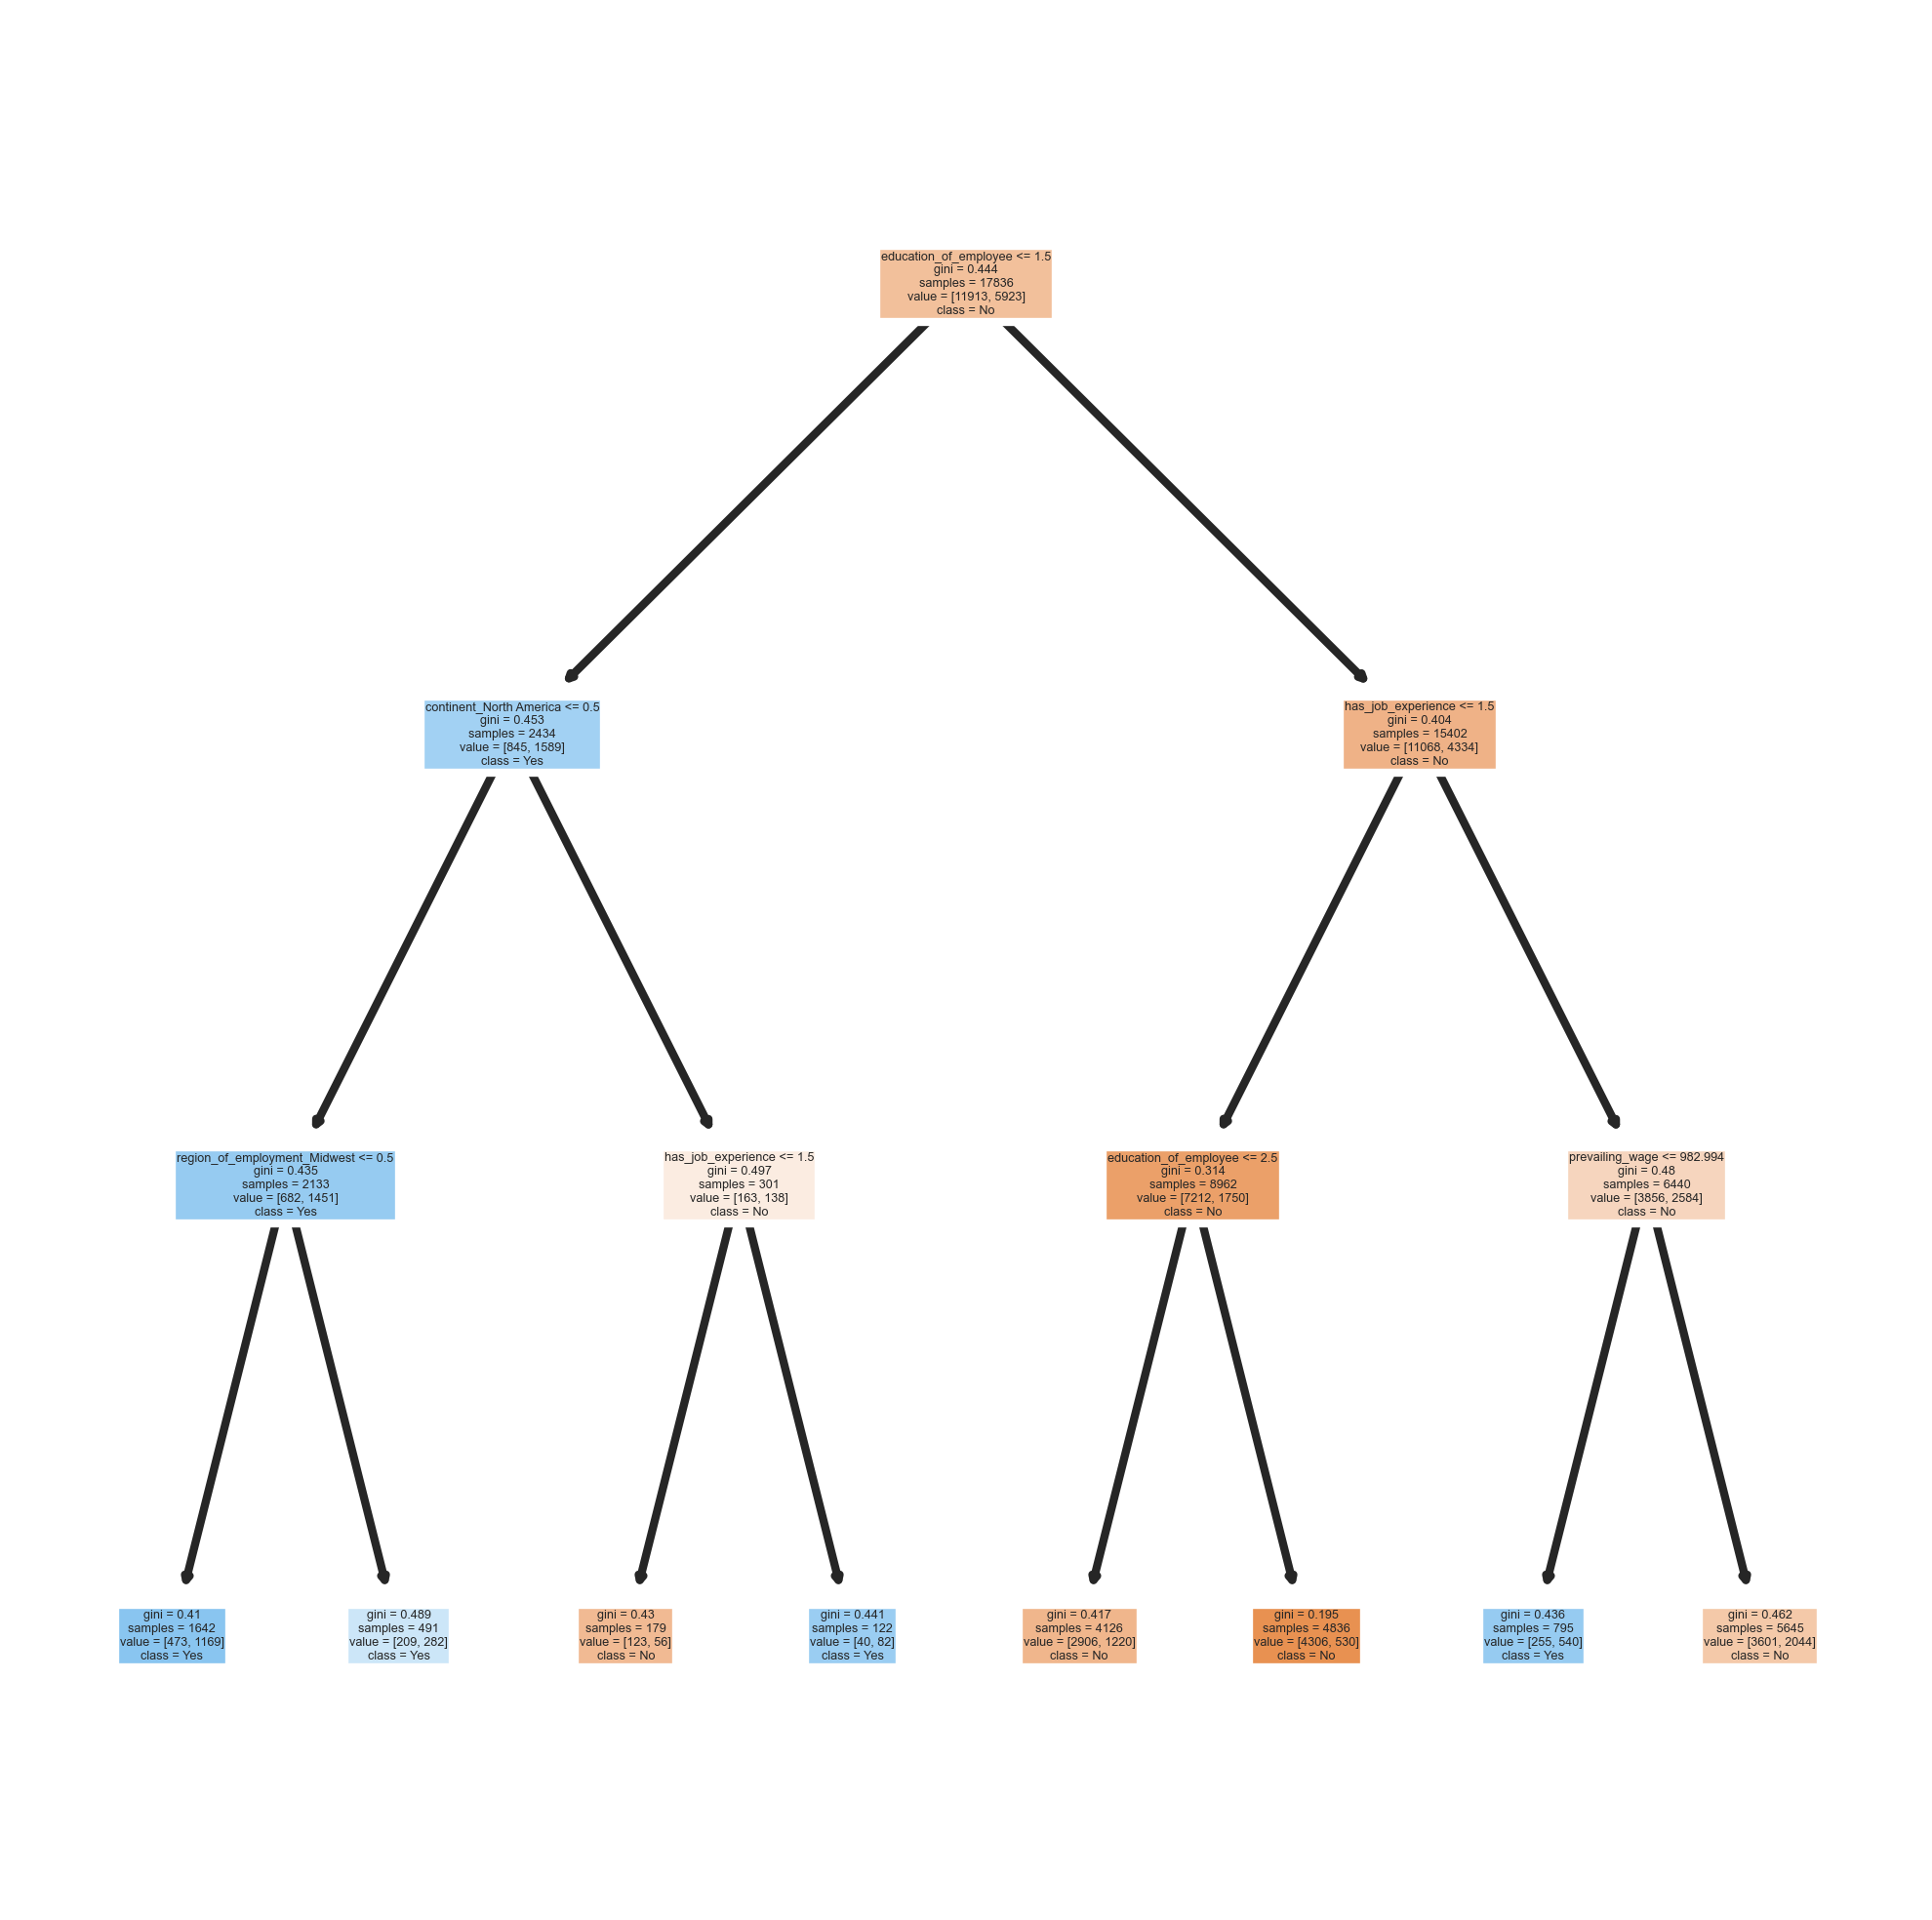

In [95]:
fn = list(X_train)
cn = ['No', 'Yes']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4, 4), dpi=600)
plot_tree(dTreeR, feature_names = fn, class_names=cn, filled = True)

fig.savefig('tree.png')

In [96]:
preds_pruned = dTreeR.predict(X_test)
preds_pruned_train = dTreeR.predict(X_train)

In [101]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix
print(accuracy_score(y_test,preds_pruned))
print(accuracy_score(y_train,preds_pruned_train))

0.7327315541601256
0.729367571204306


In [103]:
acc_DT = accuracy_score(y_test, preds_pruned)

In [105]:
print (pd.DataFrame(dTreeR.feature_importances_, columns = ["Imp"], index = X_train.columns))

                                     Imp
education_of_employee           0.586726
has_job_experience              0.269063
requires_job_training           0.000000
no_of_employees                 0.000000
yr_of_estab                     0.000000
prevailing_wage                 0.112034
full_time_position              0.000000
continent_Africa                0.000000
continent_Asia                  0.000000
continent_Europe                0.000000
continent_North America         0.020739
continent_Oceania               0.000000
continent_South America         0.000000
region_of_employment_Island     0.000000
region_of_employment_Midwest    0.011438
region_of_employment_Northeast  0.000000
region_of_employment_South      0.000000
region_of_employment_West       0.000000
unit_of_wage_Hour               0.000000
unit_of_wage_Month              0.000000
unit_of_wage_Week               0.000000
unit_of_wage_Year               0.000000


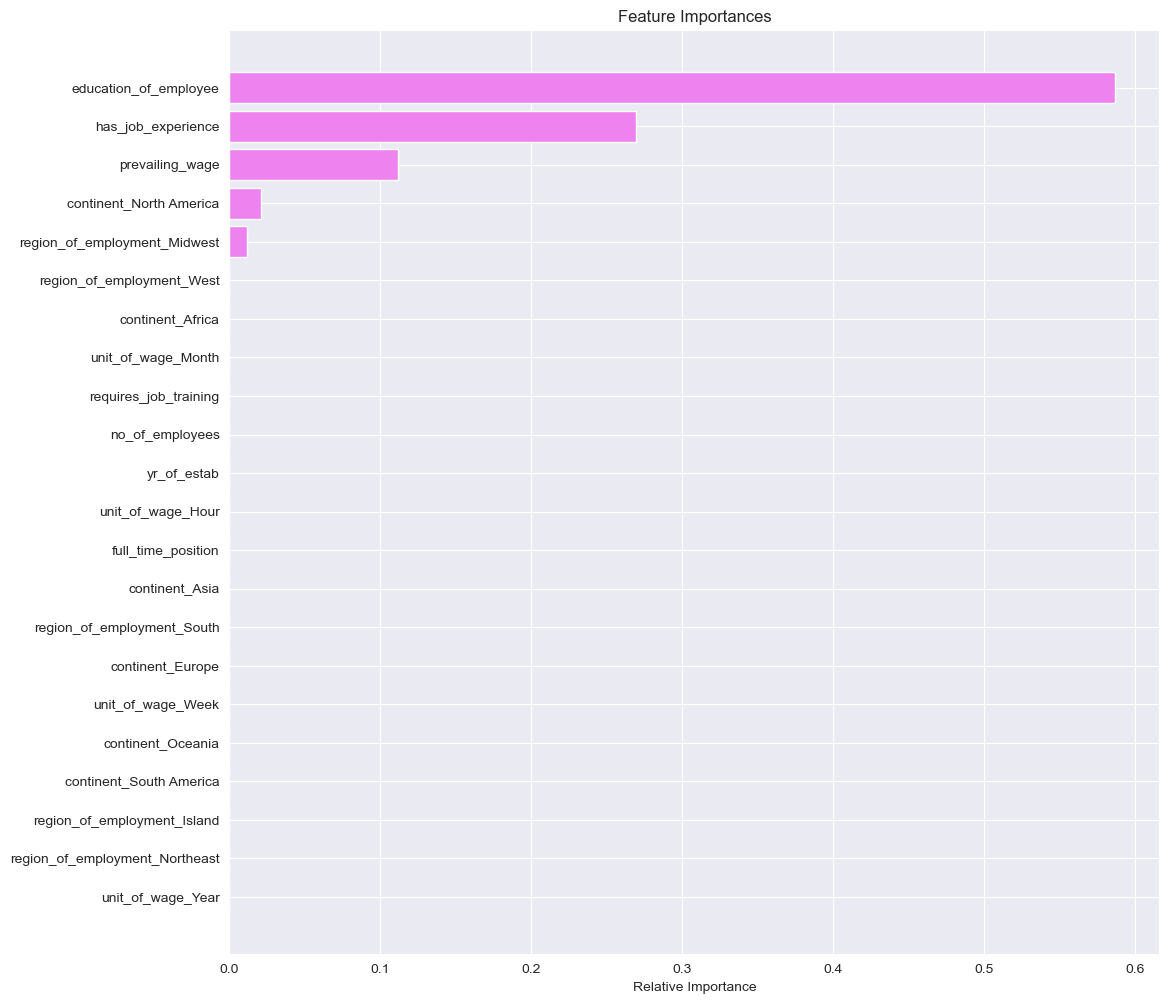

In [151]:
importances = dTreeR.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### From the feature importance dataframe we can infer that education_of_employee, has_job_experience and prevailing_wage are the variables that impact visa approval

0.7327315541601256


<Axes: >

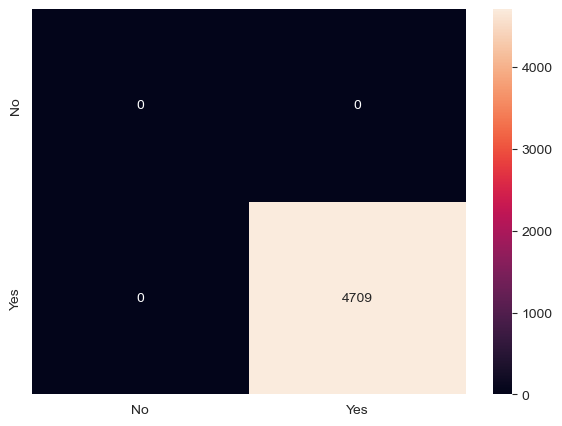

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(dTreeR.score(X_test , y_test))
y_predict = dTreeR.predict(X_test)

cm = confusion_matrix(y_test, y_predict, labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

## AdaBoosting

In [111]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(n_estimators=10, random_state=1)
abcl = abcl.fit(X_train, y_train)

In [162]:
abcl=get_metrics_score(abcl)

Accuracy on training set :  0.7302085669432609
Accuracy on test set :  0.728152799581371
Recall on training set :  0.9052295811298582
Recall on test set :  0.90871694417238
Precision on training set :  0.7454206124282851
Precision on test set :  0.7421212605983043


0.7380952380952381


<Axes: >

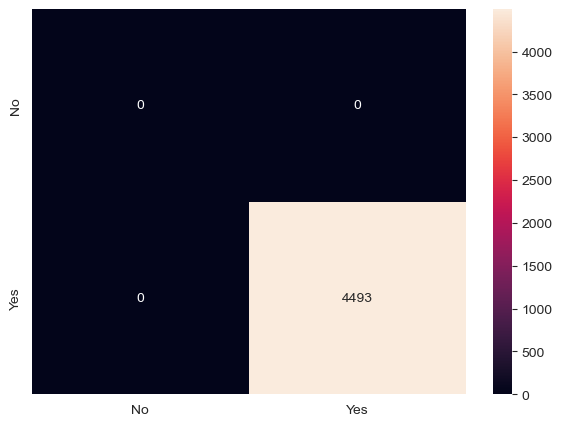

In [113]:
y_predict = abcl.predict(X_test)
print(abcl.score(X_test , y_test))

cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

- Seems like the performance has increased, and both test and recall is close enough.

## GradientBoost

In [116]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50,random_state=1)
gbcl = gbcl.fit(X_train, y_train)

In [165]:
gbcl=get_metrics_score(gbcl)

Accuracy on training set :  0.7515698587127159
Accuracy on test set :  0.7514390371533228
Recall on training set :  0.8777805758415177
Recall on test set :  0.8773751224289912
Precision on training set :  0.7785139964264444
Precision on test set :  0.7785503215713541


0.7514390371533228


<Axes: >

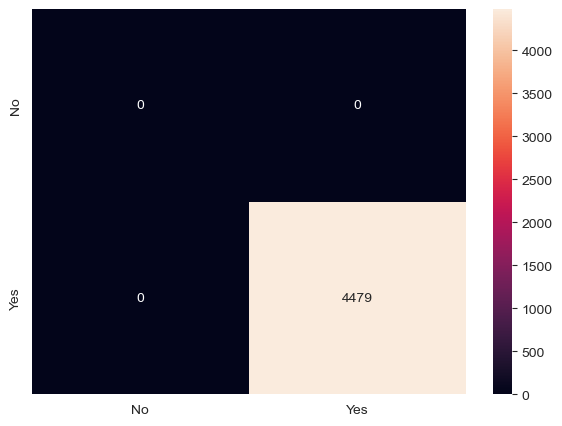

In [118]:
y_predict = gbcl.predict(X_test)
print(gbcl.score(X_test, y_test))
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

- Gradient boosting has decrease the performance than adaboosting
- Adaboosting predicted more correct than Gradient

In [120]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': acc_DT})
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

,Method,accuracy
0,Decision Tree,0.732732


In [122]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, y_train)

In [123]:
pred_RF = rfcl.predict(X_test)
acc_RF = accuracy_score(y_test, pred_RF)

In [125]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [acc_RF]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf
resultsDf

,Method,accuracy
0,Decision Tree,0.732732
0,Random Forest,0.731162


In [128]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier( n_estimators= 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train, y_train)

In [129]:
pred_AB =abcl.predict(X_test)
acc_AB = accuracy_score(y_test, pred_AB)

In [130]:
tempResultsDf = pd.DataFrame({'Method':['Adaboost'], 'accuracy': [acc_AB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf
resultsDf

,Method,accuracy
0,Decision Tree,0.732732
0,Random Forest,0.731162
0,Adaboost,0.728153


In [131]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train, y_train)

In [133]:
pred_BG =bgcl.predict(X_test)
acc_BG = accuracy_score(y_test, pred_BG)

In [136]:
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'accuracy': [acc_BG]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf
resultsDf

,Method,accuracy
0,Decision Tree,0.732732
0,Random Forest,0.731162
0,Adaboost,0.728153
0,Bagging,0.731947


In [137]:
 from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22)
gbcl = gbcl.fit(X_train, y_train)

In [138]:
pred_GB =gbcl.predict(X_test)
acc_GB = accuracy_score(y_test, pred_GB)

In [139]:
tempResultsDf = pd.DataFrame({'Method':['Gradient Boost'], 'accuracy': [acc_GB]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf
resultsDf

,Method,accuracy
0,Decision Tree,0.732732
0,Random Forest,0.731162
0,Adaboost,0.728153
0,Bagging,0.731947
0,Gradient Boost,0.751439


# For this dataset, Gradient Boosting give the best results on test predictions while Adaboosting has a better Recall

### Summary

- Education do play great importance to get a chance of Visa Certification
- Following with Education, people with work experience also do get chance of Visa Certification, though it seems not as a=high as Education.
- It seems Adaboosting will do a better, while we can still use Gradient Boosting as well.